In [1]:
import pandas as pd
import numpy as np
import pathlib as pl

from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from statannotations.Annotator import Annotator

from scipy.stats import mannwhitneyu, fisher_exact, pearsonr, kruskal

In [2]:
import sys
sys.path.append("../../FinalCode/")
import download.download as dwnl
import utils.plotting as plting
import adVMP.adVMP_discovery as discov
import adVMP.adVMP_plots as advmpplt
import adVMP.adVMP_crossval as advmpcross
import adVMP.comparison_random as rdn

In [3]:
# For figures
colors = sns.color_palette("muted")
palette = {"Normal": colors[0], "NADJ-A": colors[3], "NADJ-C": colors[2], "Adenoma": colors[3], "SSL": colors[4], "Cancer": colors[5]}
fig_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/ArticleFigures/unit")

In [4]:
base_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC/")
base_dir4 = pl.Path("/Users/josephineyates/Documents/CRC_polyp/sesame_processed_EPIC4/")

data_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/")

bad_probes = pd.read_csv(data_dir / "auxiliary" / "sketchy_probe_list_epic.csv",index_col=0).values.ravel()
sample_origin_path = pl.Path(data_dir / "clinical" / "sample_origin_wbatch.csv")

clinical_path = pl.Path(data_dir / "clinical" / "cleaned_clinical_reduced_diet.csv")
target_path = pl.Path(data_dir / "clinical" / "targets.csv")

In [5]:
EPIC2_b, EPIC2_clin, EPIC2_samples, EPIC2_phenotypes, EPIC3_b, EPIC3_clin, EPIC3_samples, EPIC3_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir, clinical_path=clinical_path, target_path=target_path,
                  bad_probes=bad_probes, EPIC4=False) 

30it [00:03,  8.40it/s]


In [6]:
EPIC4_b, EPIC4_clin, EPIC4_samples, EPIC4_phenotypes = dwnl.download_EPIC(sample_origin_path=sample_origin_path, 
                     base_dir=base_dir4, clinical_path=clinical_path, target_path=target_path, 
                  bad_probes=bad_probes, EPIC4=True) 

18it [00:03,  5.79it/s]


In [7]:
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765),
 (0.5490196078431373, 0.3803921568627451, 0.23529411764705882),
 (0.8627450980392157, 0.49411764705882355, 0.7529411764705882),
 (0.4745098039215686, 0.4745098039215686, 0.4745098039215686),
 (0.8352941176470589, 0.7333333333333333, 0.403921568627451),
 (0.5098039215686274, 0.7764705882352941, 0.8862745098039215)]

# Find adVMP

In [98]:
advmpcross.get_stratified_hyper_DMC(y=EPIC2_phenotypes.astype(int), 
                             EPIC_m=EPIC2_b, 
                             result_dir=pl.Path("../../FinalData/adVMP_crossvalidation_4fold/SWEPIC1"),
                             n_splits=4, 
                             rs=1)

Starting fold 0...


100%|█████████████████████████████████| 324053/324053 [04:08<00:00, 1301.72it/s]


Starting fold 1...


100%|█████████████████████████████████| 324053/324053 [04:07<00:00, 1308.92it/s]


Starting fold 2...


100%|█████████████████████████████████| 324053/324053 [04:07<00:00, 1307.41it/s]


Starting fold 3...


100%|█████████████████████████████████| 324053/324053 [04:09<00:00, 1297.96it/s]


In [85]:
advmpcross.get_stratified_hyper_DMC(y=EPIC3_phenotypes.astype(int), 
                             EPIC_m=EPIC3_b, 
                             result_dir=pl.Path("../../FinalData/adVMP_crossvalidation_4fold/SWEPIC2"),
                             n_splits=4, 
                             rs=0)

Starting fold 0...


100%|██████████████████████████████████| 324053/324053 [06:57<00:00, 776.94it/s]


Starting fold 1...


100%|██████████████████████████████████| 324053/324053 [06:49<00:00, 791.44it/s]


Starting fold 2...


100%|██████████████████████████████████| 324053/324053 [06:48<00:00, 793.45it/s]


Starting fold 3...


100%|██████████████████████████████████| 324053/324053 [06:55<00:00, 779.07it/s]


In [86]:
advmpcross.get_stratified_hyper_DMC(y=EPIC4_phenotypes.astype(int), 
                             EPIC_m=EPIC4_b, 
                             result_dir=pl.Path("../../FinalData/adVMP_crossvalidation_4fold/SWEPIC3"),
                             n_splits=4, 
                             rs=0)

Starting fold 0...


100%|██████████████████████████████████| 306651/306651 [06:30<00:00, 784.84it/s]


Starting fold 1...


100%|██████████████████████████████████| 306651/306651 [05:09<00:00, 989.38it/s]


Starting fold 2...


100%|█████████████████████████████████| 306651/306651 [04:06<00:00, 1243.53it/s]


Starting fold 3...


100%|█████████████████████████████████| 306651/306651 [04:05<00:00, 1246.99it/s]


# Ensembling probes

In [8]:
test_results = {}
for i in ['1','2','3']:
    direc = pl.Path(f"/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC{i}/")
    test_results[i] = {}
    for fold in direc.iterdir():
        if fold.stem==".DS_Store":
            continue
        test_results[i][fold.stem]  = pd.read_csv(fold / "adVMP_right.csv", index_col=0)

In [9]:
common_sign_probes = {}
for ds in test_results:
    common_sign_probes[ds] = []
    for i,fold in enumerate(test_results[ds]):
        df = test_results[ds][fold]
        sign = df[(df["q"]<0.001) & (df["ttest_p"]<0.05) & (df.diffV>0)]
        if i==0:
            common_sign_probes[ds] = sign.index
        else:
            common_sign_probes[ds] = np.intersect1d(common_sign_probes[ds], sign.index)

In [10]:
len(common_sign_probes["1"]),len(common_sign_probes["2"]),len(common_sign_probes["3"])

(381, 33, 530)

In [11]:
union_cpgs_fold = advmpcross.get_fold_specific_ensembling_cpgs(test_results)

In [39]:
union_cpgs_fold_noensembling = advmpcross.get_fold_specific_ensembling_cpgs(test_results, noens=True)

for ds in union_cpgs_fold_noensembling:
    for fold in union_cpgs_fold_noensembling[ds]:
        union_cpgs_fold_noensembling[ds][fold] = union_cpgs_fold_noensembling[ds][fold][0].to_numpy()

# Visualize probe performance

In [52]:
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC1/")
all_stats1, crossval_hit_fraction1 = advmpcross.get_crossval_performance(ds_dir=ds_dir, EPIC_b=EPIC2_b, 
                             union_cpgs_fold_spec=union_cpgs_fold["1"], EPIC_phenotypes=EPIC2_phenotypes, 
                             estimate_copa=True)

In [53]:
all_stats1

,fold1,fold2,fold3,fold4,Mean,Std
ROC AUC train,0.927266,0.923794,0.965826,0.905702,0.930647,0.021899
ROC AUC test,0.746711,0.569079,0.616776,0.815789,0.687089,0.098728
PR AUC train,0.929919,0.927382,0.968531,0.924613,0.937611,0.017950
PR AUC test,0.811263,0.688581,0.684043,0.851270,0.758789,0.073862


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


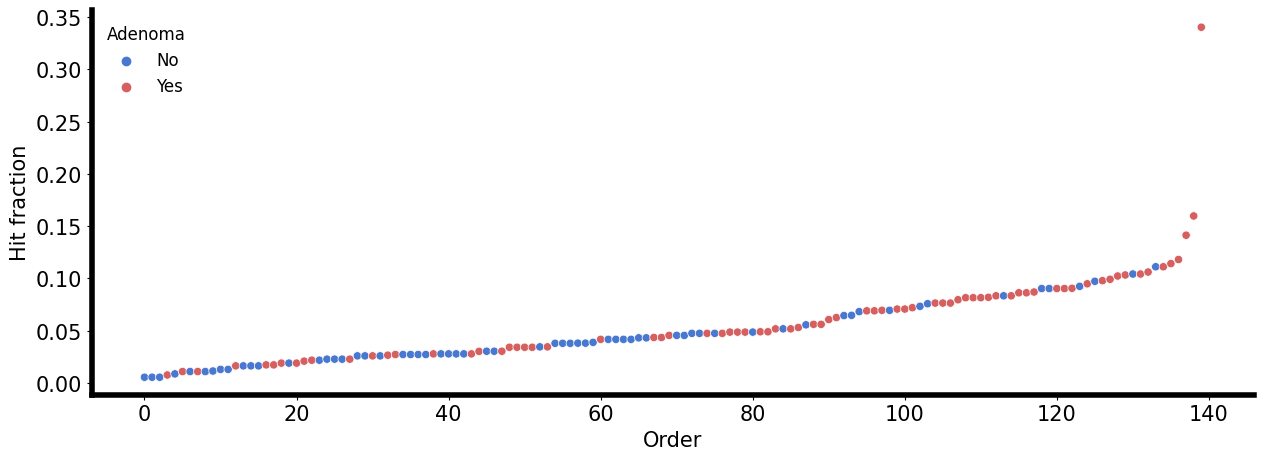

In [12]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=crossval_hit_fraction1, x="Order", y="Hit fraction", hue="Ad_plot", 
                palette={"No": colors[0], "Yes": colors[3]})
plting.transform_plot_ax(ax, legend_title="Adenoma")
fig.savefig(fig_dir / "SWEPIC1" / "crossval_worm_plot.svg", bbox_inches="tight")

In [54]:
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC2/")
all_stats2, crossval_hit_fraction2 = advmpcross.get_crossval_performance(ds_dir=ds_dir, EPIC_b=EPIC3_b, 
                             union_cpgs_fold_spec=union_cpgs_fold["2"], EPIC_phenotypes=EPIC3_phenotypes, 
                             estimate_copa=True)

In [55]:
all_stats2

,fold1,fold2,fold3,fold4,Mean,Std
ROC AUC train,0.771186,0.787768,0.798209,0.778568,0.783933,0.010121
ROC AUC test,0.698681,0.583429,0.534539,0.573011,0.597415,0.061236
PR AUC train,0.339267,0.314724,0.351324,0.388917,0.348558,0.026775
PR AUC test,0.254581,0.198821,0.146583,0.182034,0.195505,0.038974


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


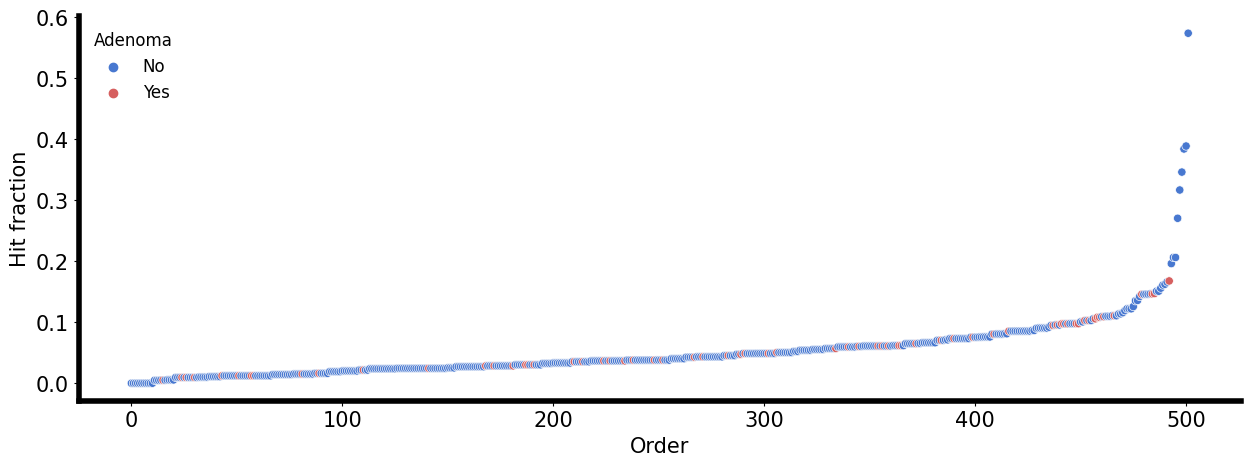

In [15]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=crossval_hit_fraction2, x="Order", y="Hit fraction", hue="Ad_plot", 
                palette={"No": colors[0], "Yes": colors[3]})
plting.transform_plot_ax(ax, legend_title="Adenoma")
fig.savefig(fig_dir / "SWEPIC2" / "crossval_worm_plot.svg", bbox_inches="tight")

In [56]:
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC3/")
all_stats3, crossval_hit_fraction3 = advmpcross.get_crossval_performance(ds_dir=ds_dir, EPIC_b=EPIC4_b, 
                             union_cpgs_fold_spec=union_cpgs_fold["3"], EPIC_phenotypes=EPIC4_phenotypes, 
                             estimate_copa=True)

In [57]:
all_stats3

,fold1,fold2,fold3,fold4,Mean,Std
ROC AUC train,0.727355,0.738283,0.770112,0.728437,0.741047,0.017312
ROC AUC test,0.710802,0.684932,0.642284,0.628311,0.666582,0.032967
PR AUC train,0.639190,0.658946,0.659287,0.637173,0.648649,0.010492
PR AUC test,0.625443,0.561569,0.550935,0.518831,0.564195,0.038704


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


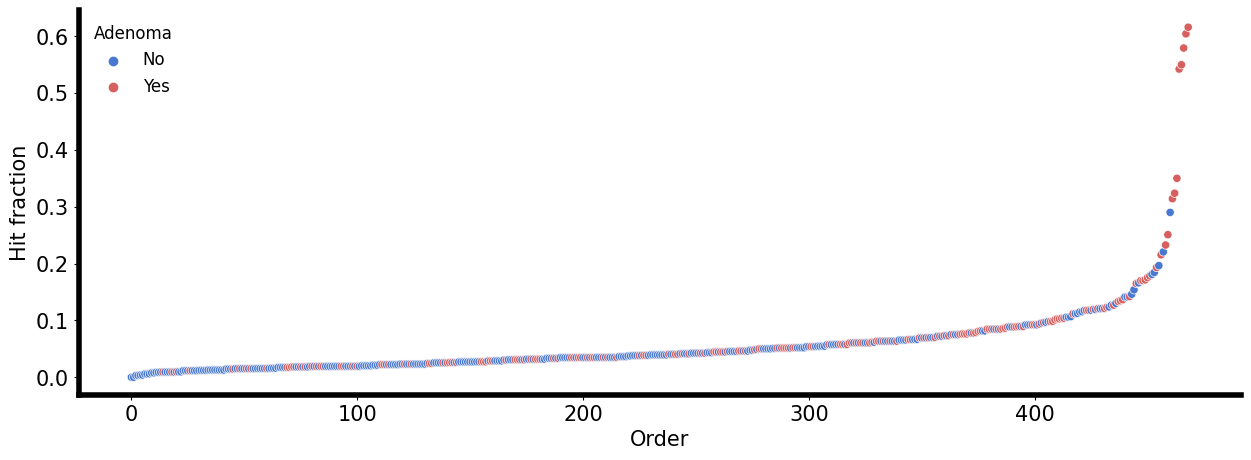

In [18]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=crossval_hit_fraction3, x="Order", y="Hit fraction", hue="Ad_plot", 
                palette={"No": colors[0], "Yes": colors[3]})
plting.transform_plot_ax(ax, legend_title="Adenoma")
fig.savefig(fig_dir / "SWEPIC3" / "crossval_worm_plot.svg", bbox_inches="tight")

In [58]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


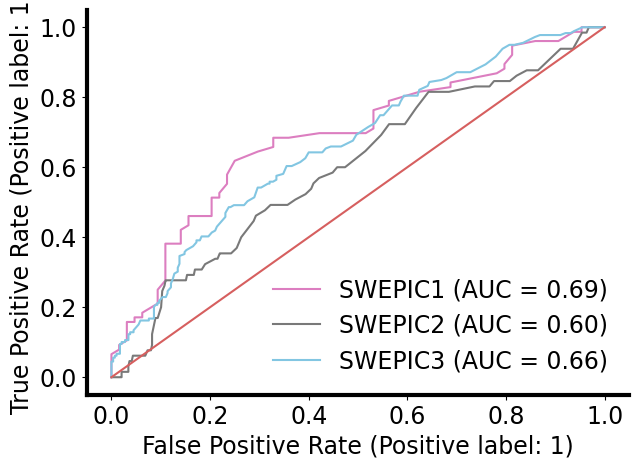

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
RocCurveDisplay.from_predictions(
    crossval_hit_fraction1["Ad"].astype(int).ravel(),
    crossval_hit_fraction1["Hit fraction"].ravel(),
    ax=ax,
    c=colors[6],
    name='SWEPIC1',
)
RocCurveDisplay.from_predictions(
    crossval_hit_fraction2["Ad"].astype(int).ravel(),
    crossval_hit_fraction2["Hit fraction"].ravel(),
    ax=ax,
    c=colors[7],
    name='SWEPIC2',
)
RocCurveDisplay.from_predictions(
    crossval_hit_fraction3["Ad"].astype(int).ravel(),
    crossval_hit_fraction3["Hit fraction"].ravel(),
    ax=ax, 
    c=colors[9],
    name='SWEPIC3',
)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c=colors[3])
plting.transform_plot_ax(ax, legend_title="", ftsize=17, leg_ftsize=17, linew=3)
fig.savefig(fig_dir / "ROC_AUC_curve_crossval.svg", bbox_inches="tight")

# Compare to random probes

100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.52it/s]
/Users/josephineyates/opt/anaconda3/envs/methylation/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


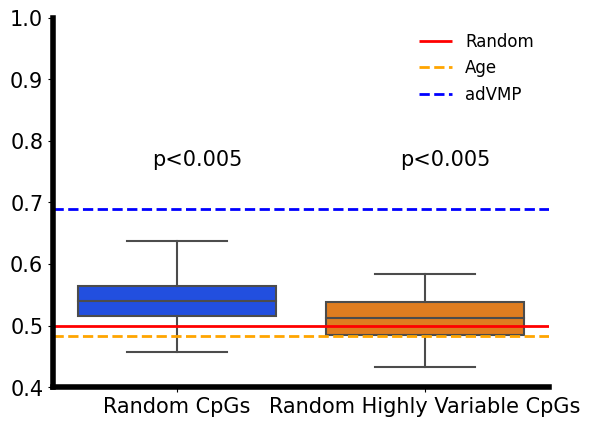

In [21]:
swepic1_ref = 0.69

background_cpgs = pd.read_csv("../../FinalData/variable_probes/union_cpgs_5_pct_most_variable_onlyhealthy.csv",index_col=0).values.ravel()
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC1/")

advmpcross.get_comparison_rdn(background_cpgs=background_cpgs, 
                       figdir=fig_dir / "SWEPIC1",
                       ref=swepic1_ref,
                       ds_dir=ds_dir, 
                       phenotypes=EPIC2_phenotypes,
                       union_cpgs_fold_spec=union_cpgs_fold["1"], 
                       data=EPIC2_b, 
                       clin=EPIC2_clin,
                       n_iter=200)

100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.54it/s]
/Users/josephineyates/opt/anaconda3/envs/methylation/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


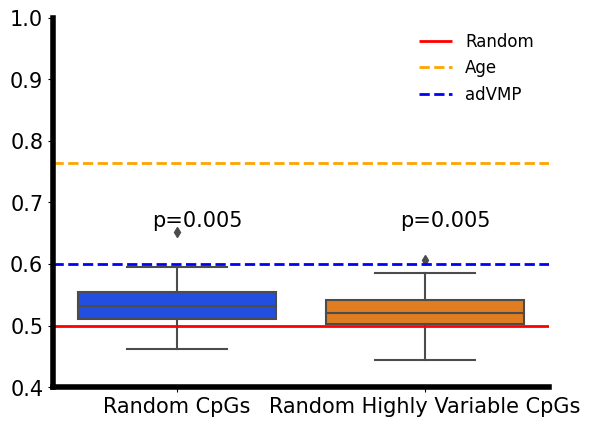

In [22]:
swepic2_ref = 0.60

background_cpgs = pd.read_csv("../../FinalData/variable_probes/union_cpgs_5_pct_most_variable_onlyhealthy.csv",index_col=0).values.ravel()
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC2/")

advmpcross.get_comparison_rdn(background_cpgs=background_cpgs, 
                       figdir=fig_dir / "SWEPIC2",
                       ref=swepic2_ref,
                       ds_dir=ds_dir, 
                       phenotypes=EPIC3_phenotypes,
                       union_cpgs_fold_spec=union_cpgs_fold["2"], 
                       data=EPIC3_b, 
                       clin=EPIC3_clin,
                       n_iter=200)

100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.53it/s]
/Users/josephineyates/opt/anaconda3/envs/methylation/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


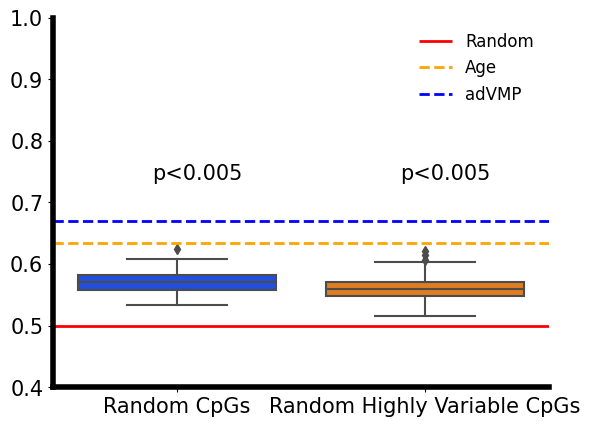

In [23]:
swepic3_ref = 0.66

background_cpgs = pd.read_csv("../../FinalData/variable_probes/union_cpgs_5_pct_most_variable_onlyhealthy.csv",index_col=0).values.ravel()
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC3/")

advmpcross.get_comparison_rdn(background_cpgs=background_cpgs, 
                       figdir=fig_dir / "SWEPIC3",
                       ref=swepic3_ref,
                       ds_dir=ds_dir, 
                       phenotypes=EPIC4_phenotypes,
                       union_cpgs_fold_spec=union_cpgs_fold["3"], 
                       data=EPIC4_b, 
                       clin=EPIC4_clin,
                       n_iter=200)

# Comparing to no ensembling probe performance

In [40]:
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC1/")
all_stats1, crossval_hit_fraction1 = advmpcross.get_crossval_performance(ds_dir=ds_dir, EPIC_b=EPIC2_b, 
                             union_cpgs_fold_spec=union_cpgs_fold_noensembling["1"], EPIC_phenotypes=EPIC2_phenotypes, 
                             estimate_copa=True)

In [41]:
all_stats1

,fold1,fold2,fold3,fold4,Mean,Std
ROC AUC train,0.994883,0.987390,0.997807,0.991959,0.993010,0.003847
ROC AUC test,0.924342,0.917763,0.723684,0.833882,0.849918,0.081139
PR AUC train,0.995375,0.988810,0.998113,0.992889,0.993797,0.003421
PR AUC test,0.949960,0.944371,0.794058,0.897615,0.896501,0.062541


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


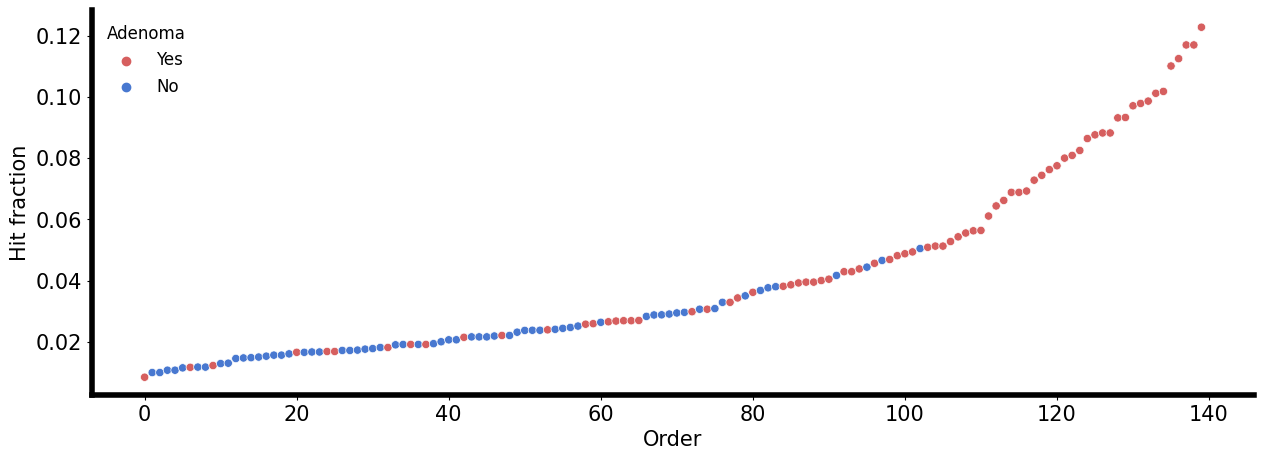

In [42]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=crossval_hit_fraction1, x="Order", y="Hit fraction", hue="Ad_plot", 
                palette={"No": colors[0], "Yes": colors[3]})
plting.transform_plot_ax(ax, legend_title="Adenoma")

In [43]:
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC2/")
all_stats2, crossval_hit_fraction2 = advmpcross.get_crossval_performance(ds_dir=ds_dir, EPIC_b=EPIC3_b, 
                             union_cpgs_fold_spec=union_cpgs_fold_noensembling["2"], EPIC_phenotypes=EPIC3_phenotypes, 
                             estimate_copa=True)

In [44]:
all_stats2

,fold1,fold2,fold3,fold4,Mean,Std
ROC AUC train,0.880724,0.869214,0.877763,0.913967,0.885417,0.017017
ROC AUC test,0.668291,0.553039,0.577712,0.553977,0.588255,0.047255
PR AUC train,0.511928,0.454097,0.501458,0.550715,0.504549,0.034427
PR AUC test,0.224884,0.164682,0.161524,0.150718,0.175452,0.029005


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


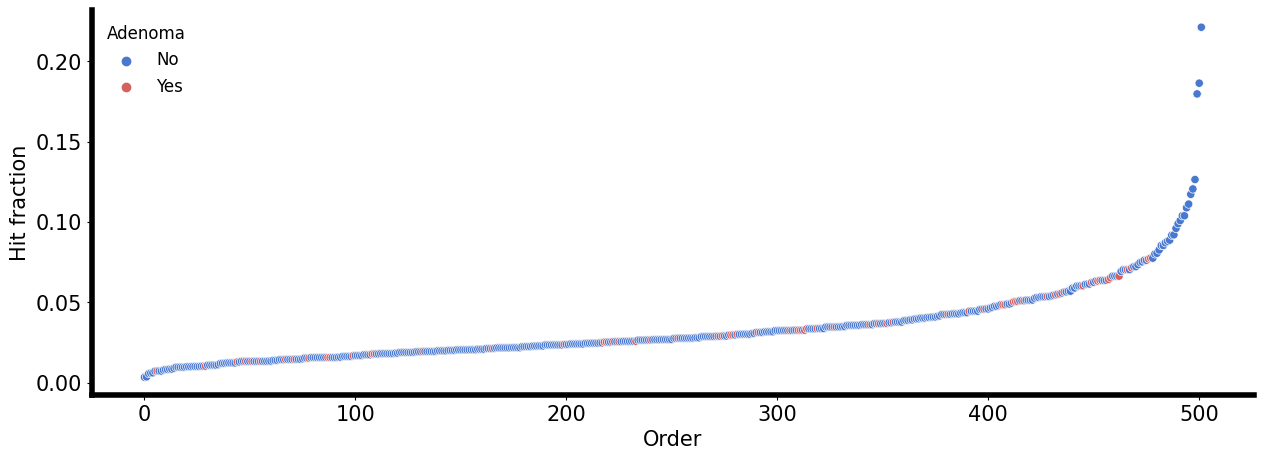

In [45]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=crossval_hit_fraction2, x="Order", y="Hit fraction", hue="Ad_plot", 
                palette={"No": colors[0], "Yes": colors[3]})
plting.transform_plot_ax(ax, legend_title="Adenoma")

In [46]:
ds_dir = pl.Path("/Users/josephineyates/Documents/CRC_polyp/FinalData/adVMP_crossvalidation_4fold/SWEPIC3/")
all_stats3, crossval_hit_fraction3 = advmpcross.get_crossval_performance(ds_dir=ds_dir, EPIC_b=EPIC4_b, 
                             union_cpgs_fold_spec=union_cpgs_fold_noensembling["3"], EPIC_phenotypes=EPIC4_phenotypes, 
                             estimate_copa=True)

In [47]:
all_stats3

,fold1,fold2,fold3,fold4,Mean,Std
ROC AUC train,0.725746,0.760693,0.765918,0.746269,0.749656,0.015568
ROC AUC test,0.714969,0.654421,0.651852,0.575342,0.649146,0.049535
PR AUC train,0.629759,0.653922,0.656363,0.644703,0.646186,0.010434
PR AUC test,0.642178,0.584407,0.542241,0.457679,0.556626,0.067247


/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


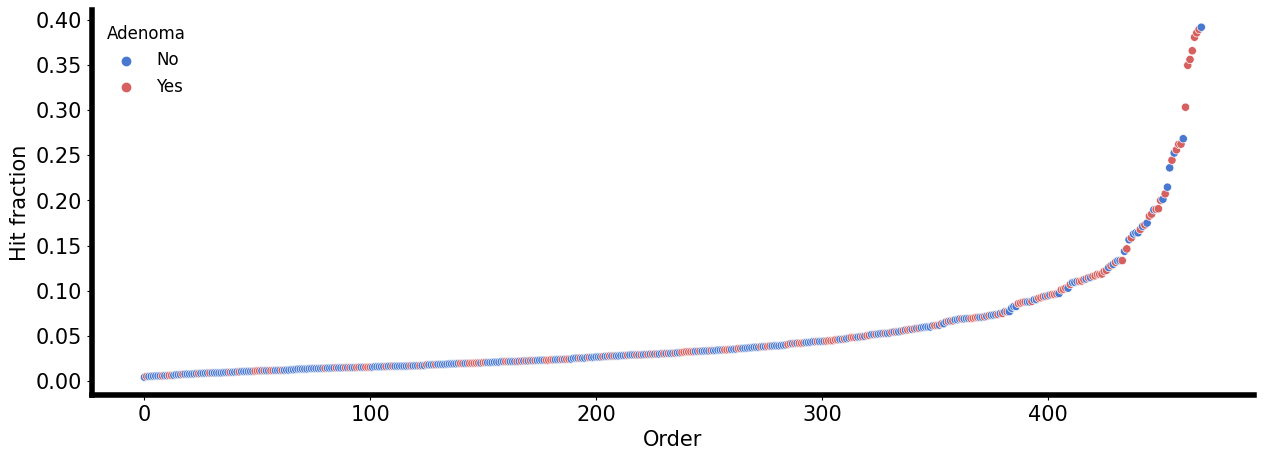

In [48]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(data=crossval_hit_fraction3, x="Order", y="Hit fraction", hue="Ad_plot", 
                palette={"No": colors[0], "Yes": colors[3]})
plting.transform_plot_ax(ax, legend_title="Adenoma")

In [49]:
from sklearn.metrics import RocCurveDisplay, PrecisionRecallDisplay

/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=ftsize)
/Users/josephineyates/Documents/CRC_polyp/FinalCode/notebooks/../../FinalCode/utils/plotting.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=ftsize)


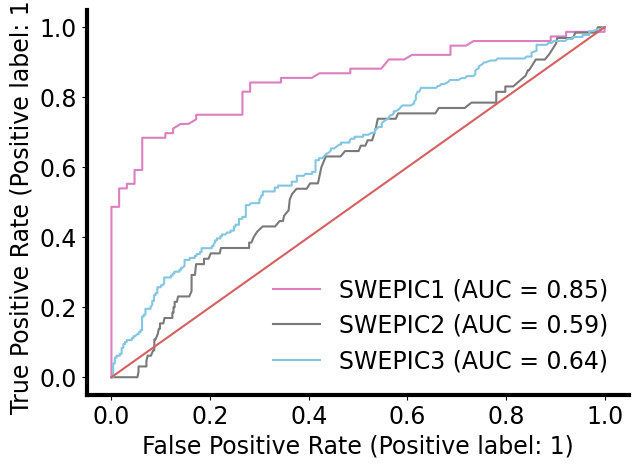

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
RocCurveDisplay.from_predictions(
    crossval_hit_fraction1["Ad"].astype(int).ravel(),
    crossval_hit_fraction1["Hit fraction"].ravel(),
    ax=ax,
    c=colors[6],
    name='SWEPIC1',
)
RocCurveDisplay.from_predictions(
    crossval_hit_fraction2["Ad"].astype(int).ravel(),
    crossval_hit_fraction2["Hit fraction"].ravel(),
    ax=ax,
    c=colors[7],
    name='SWEPIC2',
)
RocCurveDisplay.from_predictions(
    crossval_hit_fraction3["Ad"].astype(int).ravel(),
    crossval_hit_fraction3["Hit fraction"].ravel(),
    ax=ax, 
    c=colors[9],
    name='SWEPIC3',
)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), c=colors[3])
plting.transform_plot_ax(ax, legend_title="", ftsize=17, leg_ftsize=17, linew=3)
fig.savefig(fig_dir / "ROC_AUC_curve_crossval_noensembling.svg", bbox_inches="tight")